In [13]:
from torchvision.datasets import CelebA
from dataset_by_person import CelebAByPerson
from collections import Counter

import numpy as np
import seaborn as sns

In [14]:
def init_dataset():
    dataset = CelebA(root='.')
    ids = [_id for _id, _ in Counter(dataset.identity.flatten().tolist()).most_common(50)]
    dataset = CelebAByPerson(ids=ids, root='.')
    return dataset

In [15]:
dataset = init_dataset()

In [5]:
len(dataset)

1524

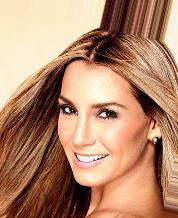

In [6]:
image, _ = dataset[0]
image

/Users/work/miniconda3/envs/face_clustering/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


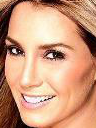

In [7]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image

mtcnn = MTCNN(margin=20, select_largest=False)
resnet = InceptionResnetV1(pretrained='vggface2').eval()

bbox, _ = mtcnn.detect(image)
image.crop(bbox[0].tolist())

In [8]:
import torch
from tqdm import tqdm

batch_size = 32
total = len(dataset)
all_faces = []
all_embeddings = []

for i in tqdm(range(0, total, batch_size)):
    lb = i
    ub = min(i + batch_size, total)
    batch = [dataset[j][0] for j in range(lb, ub)]
    
    faces = mtcnn(batch)
    
    embeddings = [
        None if face is None else resnet(face.unsqueeze(0))
        for face in faces
    ]
    
    all_faces.extend(faces)
    all_embeddings.extend(embeddings)

  2%|█▋                                                                            | 1/48 [00:03<02:28,  3.16s/it]/Users/work/miniconda3/envs/face_clustering/lib/python3.9/site-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/Users/work/miniconda3/envs/face_clustering/lib/python3.9/site-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/Users/work/miniconda3

In [9]:
ids = [int(x[1][1]) for x in dataset]

In [11]:
embedding_id_pairs = [
    (i, _id, embedding)
    for i, (_id, embedding) in enumerate(zip(ids, all_embeddings))
    if embedding is not None
]

In [12]:
dataset_ids = np.array([i for i, _, _ in embedding_id_pairs])
embeddings_arr = np.concatenate([e.detach().numpy() for _, _, e in embedding_id_pairs])
embeddings_ids = np.array([_id for _, _id, _ in embedding_id_pairs])
embeddings_arr.shape, embeddings_ids.shape

((1522, 512), (1522,))

In [13]:
np.save('dataset_ids', dataset_ids)
np.save('embeddings', embeddings_arr)
np.save('ids', embeddings_ids)

In [1]:
import numpy as np
import seaborn as sns

dataset_ids = np.load('dataset_ids.npy')
embeddings_arr = np.load('embeddings.npy')
embeddings_ids = np.load('ids.npy')
embeddings_arr.shape

(1522, 512)

In [48]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

cluster_components = 200
random_state = 42

vbgmm = BayesianGaussianMixture(
    n_components=cluster_components,
    random_state=random_state,
    verbose=2,
    weight_concentration_prior=10
)
clusters = vbgmm.fit_predict(embeddings_arr)

Initialization 0
Initialization converged: True	 time lapse 24.24480s	 ll 373191461.62595


In [49]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pca_vbgmm = Pipeline([
    ('pca', PCA(n_components=10)),
    ('svc', BayesianGaussianMixture(
        n_components=cluster_components,
        random_state=random_state,
        verbose=2,
        weight_concentration_prior=10)
    ),
])
clusters2 = pca_vbgmm.fit_predict(embeddings_arr)

Initialization 0
  Iteration 10	 time lapse 0.67709s	 ll change 67.61665
  Iteration 20	 time lapse 0.52713s	 ll change 37.40931
  Iteration 30	 time lapse 0.49905s	 ll change 5.96657
  Iteration 40	 time lapse 0.50422s	 ll change 0.72858
  Iteration 50	 time lapse 0.52652s	 ll change 4.36252
Initialization converged: True	 time lapse 3.13719s	 ll 59656.38956


In [63]:
from sklearn.cluster import KMeans

clusters3 = KMeans(n_clusters=cluster_components) \
    .fit_predict(embeddings_arr)

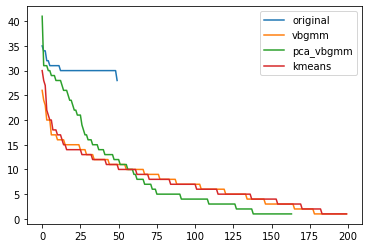

In [64]:
from collections import Counter
import matplotlib.pyplot as plt

most_common_cluster = Counter(clusters).most_common(200)
most_common_cluster2 = Counter(clusters2).most_common(200)
most_common_cluster3 = Counter(clusters3).most_common(200)

plt.plot([b for a, b in Counter(embeddings_ids).most_common(200)], label='original')
plt.plot([b for a, b in most_common_cluster], label='vbgmm')
plt.plot([b for a, b in most_common_cluster2], label='pca_vbgmm')
plt.plot([b for a, b in most_common_cluster3], label='kmeans')
plt.legend()
plt.show()

In [59]:
print(most_common_cluster[:10])
print(most_common_cluster[-100:-90])
print()
print(most_common_cluster2[:10])
print(most_common_cluster2[-100:-90])

[(72, 26), (71, 24), (8, 23), (17, 20), (95, 20), (178, 20), (127, 17), (25, 17), (144, 17), (53, 17)]
[(138, 7), (51, 7), (148, 7), (163, 7), (41, 6), (13, 6), (85, 6), (14, 6), (90, 6), (68, 6)]

[(73, 41), (76, 31), (180, 31), (145, 31), (172, 30), (19, 30), (53, 29), (58, 29), (113, 29), (13, 28)]
[(85, 8), (139, 8), (107, 8), (128, 7), (117, 7), (149, 7), (157, 7), (102, 7), (100, 6), (44, 6)]


In [34]:
def draw_people_in_group(gid, clusters, dataset_id, dataset, figsize):
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=figsize)
    imgs = []
    for g, d in zip(clusters, dataset_id):
        if g == gid:
            imgs.append(dataset[d][0])
    for img, ax in zip(imgs, axes.flatten()):
        ax.imshow(img)
    plt.show()

In [35]:
dataset_by_person = init_dataset()

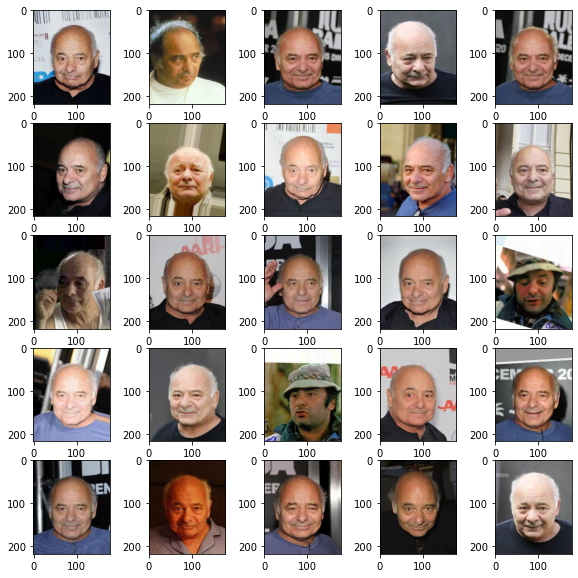

In [39]:
draw_people_in_group(14, clusters, dataset_ids, dataset_by_person, figsize=(10, 10))

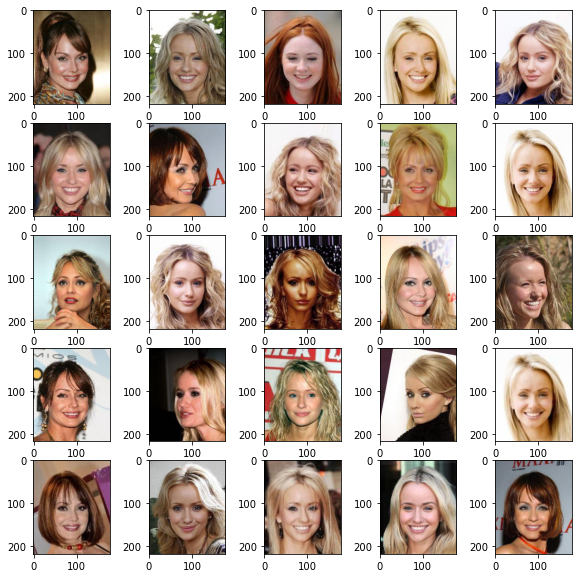

In [65]:
draw_people_in_group(73, clusters2, dataset_ids, dataset_by_person, figsize=(10, 10))

In [3]:
person_id_mappings = {_id: i for i, _id in enumerate(sorted(np.unique(embeddings_ids)))}
ids_mapped = [person_id_mappings[_id] for _id in embeddings_ids]

In [4]:
len(clusters), len(ids_mapped)

(1522, 1522)

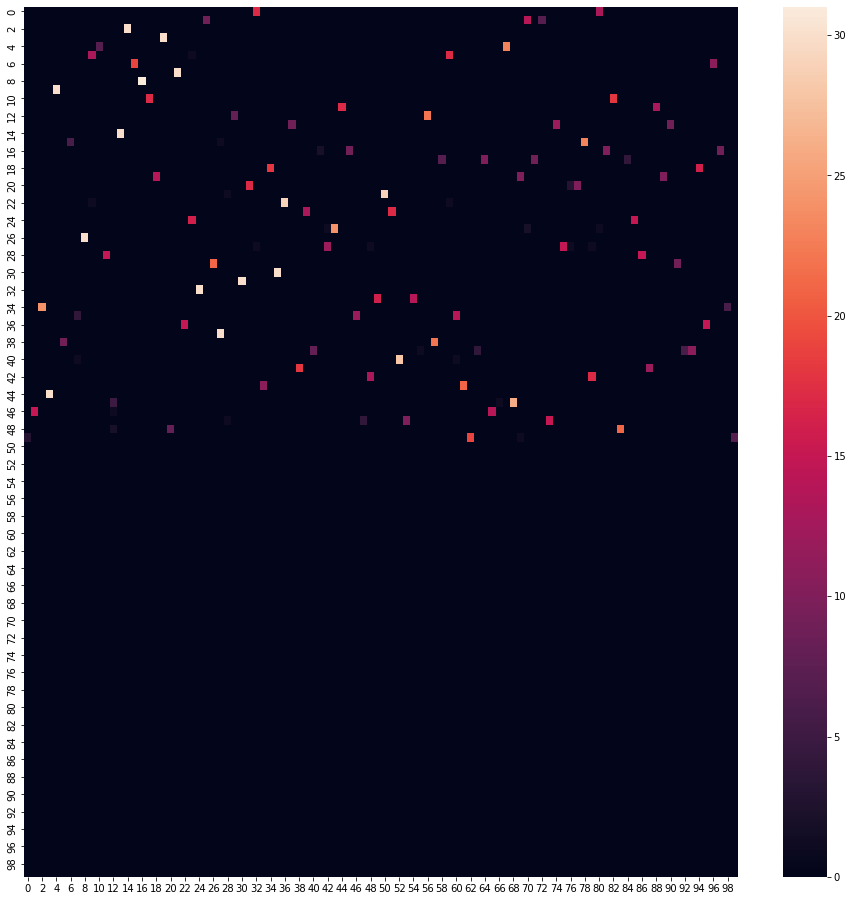

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(ids_mapped, clusters)

plt.figure(figsize=(16, 16))
ax = sns.heatmap(cm)  # , annot=True, fmt="d", cmap="Blues")